# Simulation and Noise Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../')

We can set up a noise model, following the [Qiskit textbook](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html#Correcting-errors-in-qubits). We define our noise model to have equal chances of X and Z:

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise_model(p_err):

    error_gate1 = pauli_error([("X", p_err / 3),("Y", p_err / 3), ("Z", p_err / 3), ("I", 1 - p_err)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "id")
    return noise_model

We set up a test harness to run through some examples:

In [4]:
import sys
import os

sys.path.insert(0, ".." + os.sep)
from benchmarking.benchmarking_tools import SurfaceCodeBenchmarkingTool
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from surface_code.fitters import GraphDecoder
from surface_code.circuits import SurfaceCodeLogicalQubit
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
from tqdm import tqdm

import multiprocessing as mp

In [5]:
logical = []
noise = [5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2]
d = 3
T = 1

qubit = SurfaceCodeLogicalQubit(d)
qubit.stabilize()
qubit.identity_data()
qubit.stabilize()
qubit.readout_z()
#qubit.draw(output='mpl', fold=50)

In [6]:
benchmarking_tool = SurfaceCodeBenchmarkingTool(
    decoder=GraphDecoder(d=d, T=T),
    readout_circuit=qubit,
    noise_model_func=get_noise_model,
)

#print("\nSIMULATE: (d={},T={})\n".format(benchmarking_tool.d, benchmarking_tool.T))
correct_logical_value = 0
noise_values = [
    5e-5,
    1e-4,
    2e-4,
    5e-4,
    1e-3,
    2e-3,
    4e-3,
    5e-3,
    6e-3,
    7e-3,
    8e-3,
    9e-3,
    1e-2,
    2e-2,
]
benchmarking_tool.simulate_readout(correct_logical_value=correct_logical_value, noise_values=noise_values, shots=1000, save_data=False)
print("Done!")

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.18it/s]

Done!


In [27]:
def get_results():
    for noise_value in tqdm(noise_values):
        results = (execute(qubit,Aer.get_backend("qasm_simulator"),noise_model=get_noise_model(noise_value),
                       shots=100,).result().get_counts())
    print(results)
    
    return results
x = get_results()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  8.85it/s]

{'0 00100000 00100000': 6, '0 01100000 01100000': 6, '0 10110000 10110000': 5, '0 11110000 11110000': 6, '0 10000000 10000000': 6, '0 10110100 11110000': 1, '0 11000000 11000000': 10, '0 00010000 00010000': 2, '0 10100000 10100000': 4, '0 10010000 10010000': 7, '0 00110000 00110000': 7, '0 01110000 01110000': 9, '0 00000000 00000000': 6, '0 10001000 10000000': 1, '0 01010000 01010000': 4, '0 11100000 11100000': 3, '0 00001101 11100000': 1, '0 00100000 00000000': 1, '0 00000000 00100000': 1, '0 11010000 11010000': 5, '0 01000000 01000000': 5, '1 00000010 00100000': 1, '1 11000001 11000000': 1, '1 10010001 10010000': 1, '0 11010000 00010000': 1}


In [65]:
def get_syndrome_new(synd):

    final_results = [[],[],[],[]]
    
    for row in synd:    
        #print (row)
        segments = row.split()            
        #print (segments)
        for i in range(len(segments)):
            final_results[i].append(segments[i])
    
    for item in synd.values():
        final_results[3].append(item)
        
    return final_results  
print(np.array(get_syndrome_new(x)[3]))


[ 6  6  5  6  6  1 10  2  4  7  7  9  6  1  4  3  1  1  1  5  5  1  1  1
  1]


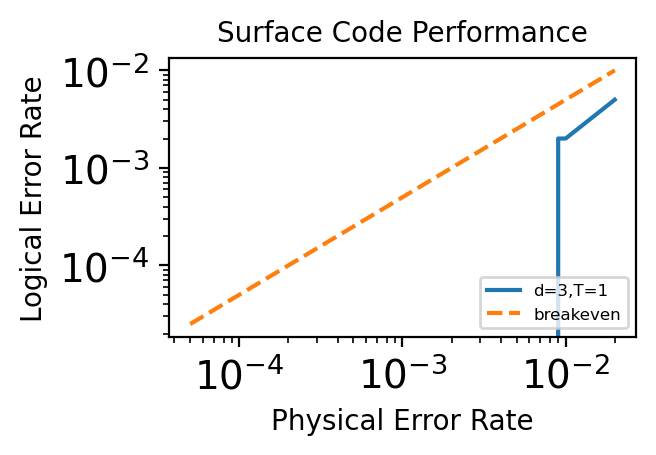

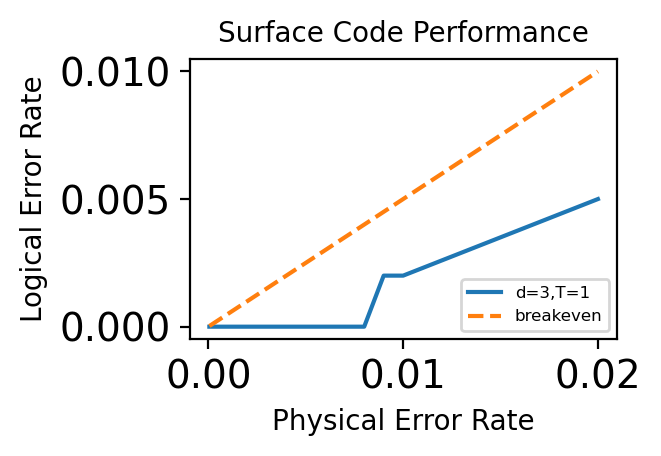

In [7]:
import matplotlib.pyplot as plt
import numpy as np
for log_plot in [True, False]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    ax = fig.subplots()
    benchmarking_tool.plot_benchmark_data(
        fig=fig,
        ax=ax,
        label="d={},T={}".format(benchmarking_tool.d, benchmarking_tool.T),
        log=log_plot,
    )
    plt.plot(
        benchmarking_tool.benchmark_data["noise"],
        0.5 * np.array(benchmarking_tool.benchmark_data["noise"]),
        "--",
        label="breakeven",
    )
    plt.legend(loc="lower right", prop={"size": 6})
    ax.set_xlabel("Physical Error Rate", size=10)
    ax.set_ylabel("Logical Error Rate", size=10)
    ax.set_title("Surface Code Performance", size=10)
    fig.tight_layout()
    plt.show()



So, we see the d=3, T=1 surface code does quite well for this particular error model!